/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Validation data successfully augmented 2640
Validation data successfully augmented 2640
Directories combined successfully into ../COMBINED_TRAINING/
Found 8742 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.0650 - loss: 3.1099
274/274 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - accuracy: 0.1170 - loss: 2.8234
Metrics Before Training:
 - Training   -> Loss: 2.8267, Accuracy: 0.1135
 - Test -> Loss: 2.8467, Accuracy: 0.1182
Epoch 1/19
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - accuracy: 0.4713 - loss: 1.6019 - val_accuracy: 0.6909 - val_loss: 0.9885
Epoch 2/19
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.7664 - loss: 0.7111 - val_accuracy: 0.7455 - val_loss: 0.8920
Epoch 3/19
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - accuracy: 0.8228 - loss: 0.5517 - val_accuracy: 0.7227 - val_loss: 0.8950
Epoch 4/19
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accuracy: 0.8527 - loss: 0.4705 - val_accuracy: 0.

,precision,recall,f1-score,support
american_house_spider,0.950000,0.950000,0.950000,20.000000
bedbug,0.642857,0.450000,0.529412,20.000000
brown_stink_bug,0.750000,0.750000,0.750000,20.000000
carpenter_ant,0.761905,0.800000,0.780488,20.000000
cellar_spider,0.833333,1.000000,0.909091,20.000000
flea,0.464286,0.650000,0.541667,20.000000
house_centipede,0.947368,0.900000,0.923077,20.000000
rice_weevil,0.705882,0.600000,0.648649,20.000000
silverfish,1.000000,0.750000,0.857143,20.000000
subterranean_termite,0.761905,0.800000,0.780488,20.000000


<Figure size 800x600 with 0 Axes>

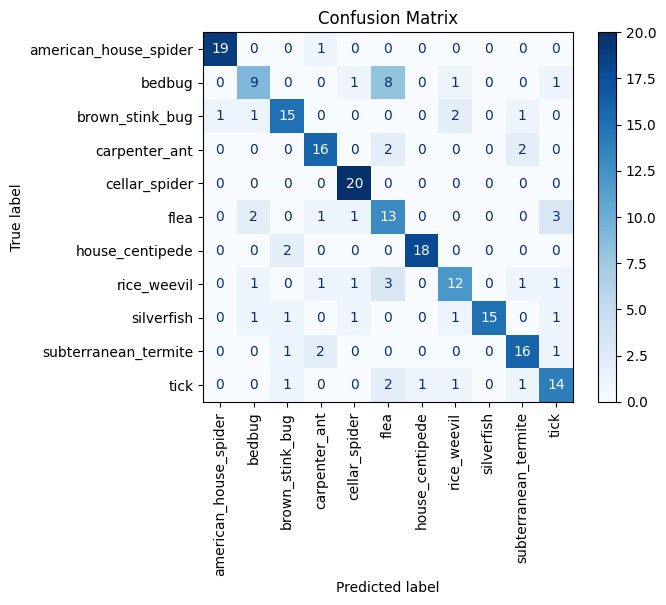

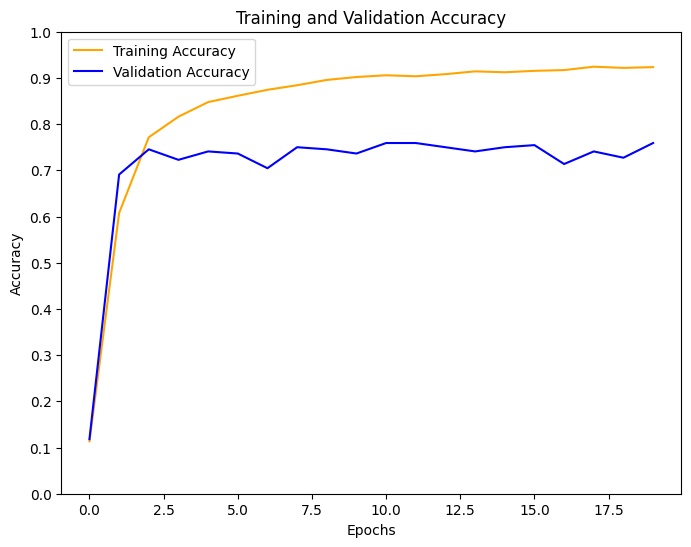

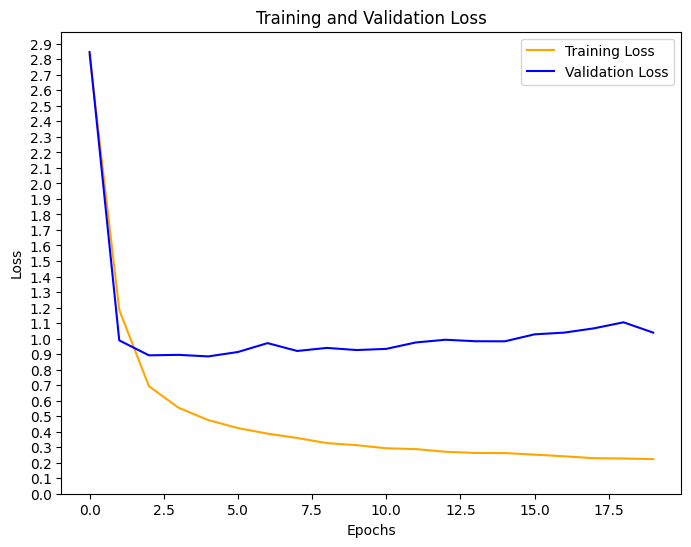

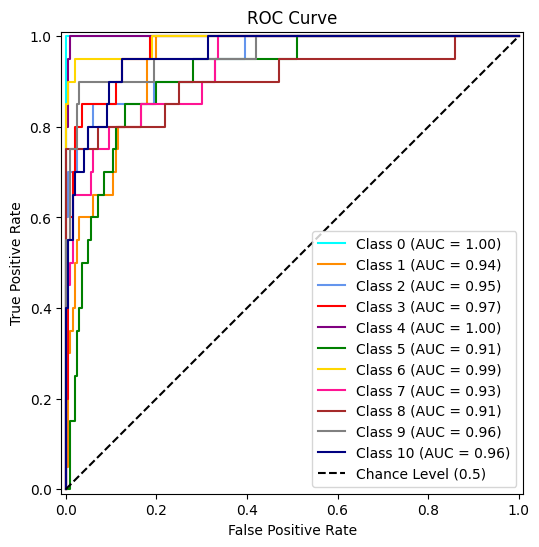

Macro-averaged One-vs-Rest ROC AUC score: 0.96
Accuracy: 0.759
Precision: 0.771
Recall: 0.759
F1 Score: 0.759


In [1]:
# FILE DESCRIPTION: -------------------------------------------------------

# This file builds and trains a MobileNetV2 model using combined
# training and validation datasets for pest classification. Final model is 
# based on the optimal hyperparamter results from the Model Tuning Scripts.

# --------------------------------------------------------------------------



# ----------- IMPORTS ----------------

# Libraries for building convolutional neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Libraries for tuning models
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import keras
from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from keras.callbacks import History, EarlyStopping
from tensorflow.keras.regularizers import l2

# Utility libraries
import os
import time
import itertools
import random
import numpy as np
import sys
import shutil
from pathlib import Path
from PIL import Image

# Commonly used functions
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)
from global_bug_bot_functions import *
from data_processing_pipeline import *



# ----------- CONSTANTS ----------------

# Set random seeds for reproducibility
SEED_VALUE = 2025
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
keras.utils.set_random_seed(SEED_VALUE)

# Constants for data directories
ALL_PROCESSED_DATA = "PROCESSED_DATA/"
VALIDATION_DATA = f'{ALL_PROCESSED_DATA}VALIDATION_DATA/'
TEST_DATA = f'{ALL_PROCESSED_DATA}TEST_DATA/'
TRAINING_DATA = f'{ALL_PROCESSED_DATA}TRAINING_DATA/'
AUGMENTED_OUTPUT_DIR = f'{TRAINING_DATA}TRAINING_AUGMENTED_DATA/'

# Hold training + validation augmented data for final model
COMBINED_TRAINING = "../COMBINED_TRAINING/"
os.makedirs(COMBINED_TRAINING, exist_ok=True)

AUGMENTED_VALID = '../AUGMENTED_VALID/'
os.makedirs(AUGMENTED_VALID, exist_ok=True)

# Best hyperparameters from tuning (found in Model Tuning Scripts)
BEST_LR = 0.001
BEST_DROPOUT = 0.2
BEST_BATCH_SIZE = 64
BEST_EPOCHS = 19



# ----------- FUNCTIONS ----------------

def augment_validation_data(validation_data_dir, augmented_output_dir):
    """
    Augments validation
    
    Parameters:
        validation_data_dir - str: Path to the validation data directory
        augmented_output_dir -str: Path where augmented validation images will be saved
    
    Returns:
        number of augmented images
    """

    if not isinstance(validation_data_dir, str):
        raise TypeError("validation_data_dir must be a string.")
    if not isinstance(augmented_output_dir, str):
        raise TypeError("augmented_output_dir must be a string.")
    
    # ---- AUGMENT VALIDATION PRIOR TO JOINING WITH TRAINING ----

    successfully_augmented = 0
    for folder in get_folders(validation_data_dir):
        source_dir = os.path.join(validation_data_dir, folder) 

        if not os.path.exists(source_dir):
            print(f"Skipping missing directory: {source_dir}")
            continue

        output_subdir = os.path.join(augmented_output_dir, folder)
        os.makedirs(output_subdir, exist_ok=True)

        for file in os.listdir(source_dir):
            file_path = os.path.join(source_dir, file)

            # saving info needed for output file saving
            base_filename, file_extension = os.path.splitext(file)

            if os.path.isfile(file_path):
                # read image as Image object
                processed_img = Image.open(file_path)

                # perform and save augmentations
                final_img_success, augment_error_log = augment_image(processed_img, output_subdir, base_filename)

                if final_img_success == True:
                    successfully_augmented += 6
                else:
                    print(augment_error_log)

    print('Validation data successfully augmented', successfully_augmented)
    return successfully_augmented


def combine_directories(dir1: str, dir2: str, output_dir: str) -> None:
    """
    Combine contents of two directories into a third directory

    Parameters:
      dir1: Path to first source directory (e.g., training data).
      dir2: Path to second source directory (e.g., validation data).
      output_dir: Path to destination directory
    """

    if not all(isinstance(p, str) for p in [dir1, dir2, output_dir]):
        raise TypeError("All directory paths must be strings")

    os.makedirs(output_dir, exist_ok=True)
    subdirs_set = set()

    for root, _, _ in os.walk(dir1):
        rel_path = os.path.relpath(root, dir1)
        if rel_path != '.':
            subdirs_set.add(rel_path)
    for root, _, _ in os.walk(dir2):
        rel_path = os.path.relpath(root, dir2)
        if rel_path != '.':
            subdirs_set.add(rel_path)

    for subdir in subdirs_set:
        os.makedirs(os.path.join(output_dir, subdir), exist_ok=True)

    for source in [dir1, dir2]:
        for root, _, files in os.walk(source):
            rel_path = os.path.relpath(root, source)
            dest_path = os.path.join(output_dir, rel_path)
            for file in files:
                src_file = os.path.join(root, file)
                dest_file = os.path.join(dest_path, file)
                if not os.path.exists(dest_file):
                    shutil.copy2(src_file, dest_file)


def build_mobilenet_model(input_shape: tuple, num_classes: int, dropout_rate: float, learning_rate: float) -> Model:
    """
    Build and compile the final MobileNetV2 model with parameters found from tuner script

    Parameters:
        input_shape: shape of the input images
        num_classes: number of output classes
        dropout_rate: dropout rate for regularization
        learning_rate: learning rate for the optimizer

    Returns:
        Keras model
    """

    if not isinstance(input_shape, tuple):
        raise TypeError("input_shape must be a tuple")

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = BatchNormalization()(base_model.output)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def main():
    """
    Main function that augments the validation data, combines the training & validation data,
    builds, trains, and evaluates the final model.
    """

    # 1) Augment validation data
    os.makedirs(AUGMENTED_VALID, exist_ok=True)
    augmented_count = augment_validation_data(VALIDATION_DATA, AUGMENTED_VALID)
    print('Validation data successfully augmented', augmented_count)

    # 2) Combine training and validation data
    os.makedirs(COMBINED_TRAINING, exist_ok=True)
    combine_directories(AUGMENTED_OUTPUT_DIR, AUGMENTED_VALID, COMBINED_TRAINING)
    print(f"Directories combined successfully into {COMBINED_TRAINING}")

    # 3) Load combined training and test data
    TRAINING_FINAL = load_data(COMBINED_TRAINING)
    TRAIN_GENERATOR = TRAINING_FINAL
    TEST_GENERATOR = load_data(TEST_DATA, shuffle_flag=False)

    # 4) Build model
    model = build_mobilenet_model((224, 224, 3), TRAIN_GENERATOR.num_classes, BEST_DROPOUT, BEST_LR)

    # 5) Evaluate before training
    initial_loss_test, initial_accuracy_test = model.evaluate(TEST_GENERATOR)
    initial_loss_train, initial_accuracy_train = model.evaluate(TRAIN_GENERATOR)
    print("Metrics Before Training:")
    print(f" - Training   -> Loss: {initial_loss_train:.4f}, Accuracy: {initial_accuracy_train:.4f}")
    print(f" - Test -> Loss: {initial_loss_test:.4f}, Accuracy: {initial_accuracy_test:.4f}")

    # 6) Train the model
    history = model.fit(
        TRAIN_GENERATOR,
        validation_data=TEST_GENERATOR,
        epochs=BEST_EPOCHS,
        batch_size=BEST_BATCH_SIZE
    )

    # 7) Pretraining metrics for plotting
    history.history['accuracy'].insert(0, initial_accuracy_train)
    history.history['loss'].insert(0, initial_loss_train)
    history.history['val_accuracy'].insert(0, initial_accuracy_test)
    history.history['val_loss'].insert(0, initial_loss_test)

    # 8) Evaluate the model using evaluation metrics
    evaluation_metrics(model, TEST_GENERATOR, history)


    # --------------------------------------------------------------------------
    # TEST CASE / EXPECTED RESULTS when this script is run:

        # 2640 images in validation set should be augmented
        # Folder called AUGMENTED_VALID that contains the augmented validation images 
        # Folder called COMBINED_TRAINING that contains both validation + testing images
        # COMBINED_TRAINING should contain 8742 images belonging to 11 classes
    
        # time completion: around ~10-12 minutes
    # --------------------------------------------------------------------------



if __name__ == "__main__":
    main()


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Validation data successfully augmented 2640
Validation data successfully augmented 2640
Directories combined successfully into ../COMBINED_TRAINING/
Found 8742 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.0650 - loss: 3.1099
274/274 ━━━━━━━━━━━━━━━━━━━━ 33s 122ms/step - accuracy: 0.1170 - loss: 2.8234
Metrics Before Training:
 - Training   -> Loss: 2.8267, Accuracy: 0.1135
 - Test -> Loss: 2.8467, Accuracy: 0.1182
Epoch 1/19
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - accuracy: 0.4713 - loss: 1.6019 - val_accuracy: 0.6909 - val_loss: 0.9885
Epoch 2/19
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.7664 - loss: 0.7111 - val_accuracy: 0.7455 - val_loss: 0.8920
Epoch 3/19
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.8228 - loss: 0.5517 - val_accuracy: 0.7227 - val_loss: 0.8950
Epoch 4/19
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accuracy: 0.8527 - loss: 0.4705 - val_accuracy: 0.

,precision,recall,f1-score,support
american_house_spider,0.950000,0.950000,0.950000,20.000000
bedbug,0.642857,0.450000,0.529412,20.000000
brown_stink_bug,0.750000,0.750000,0.750000,20.000000
carpenter_ant,0.761905,0.800000,0.780488,20.000000
cellar_spider,0.833333,1.000000,0.909091,20.000000
flea,0.464286,0.650000,0.541667,20.000000
house_centipede,0.947368,0.900000,0.923077,20.000000
rice_weevil,0.705882,0.600000,0.648649,20.000000
silverfish,1.000000,0.750000,0.857143,20.000000
subterranean_termite,0.761905,0.800000,0.780488,20.000000


<Figure size 800x600 with 0 Axes>

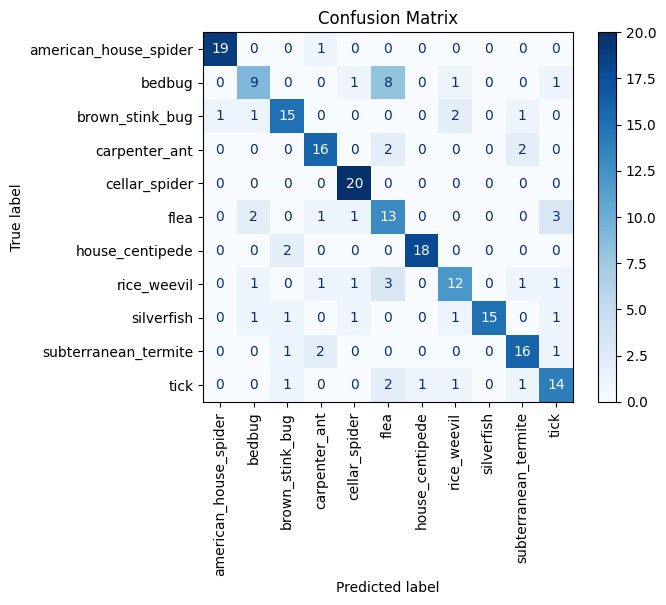

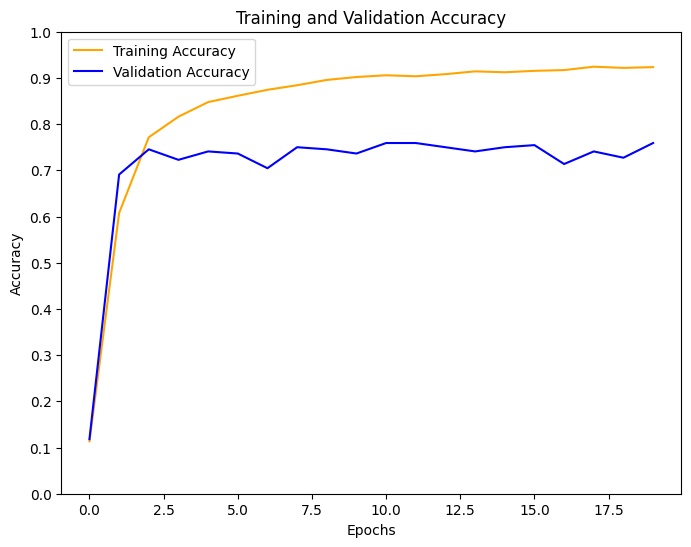

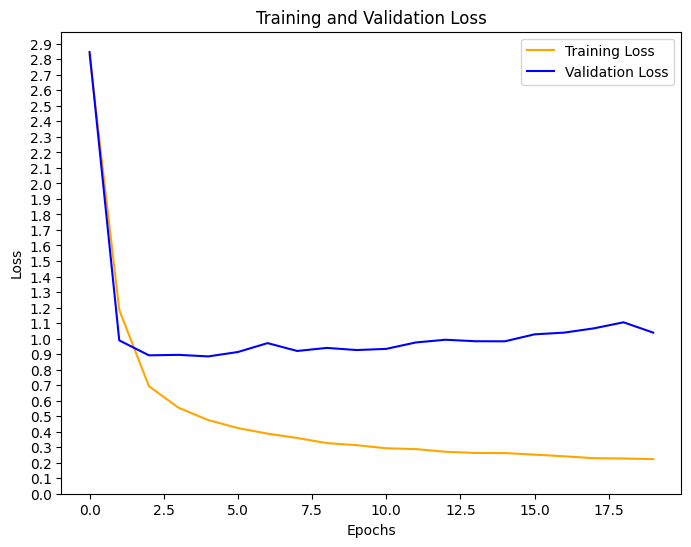

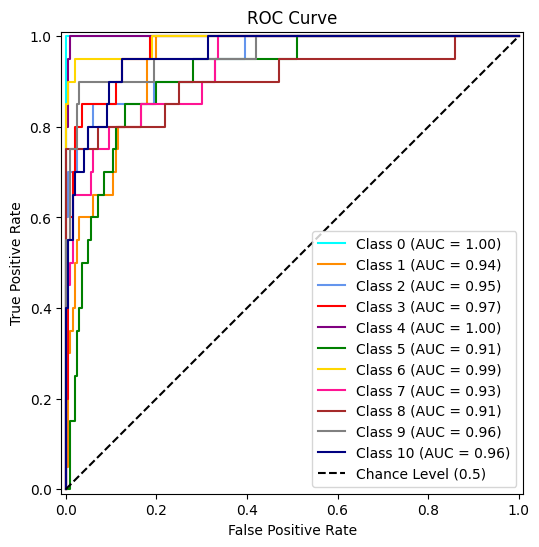

Macro-averaged One-vs-Rest ROC AUC score: 0.96
Accuracy: 0.759
Precision: 0.771
Recall: 0.759
F1 Score: 0.759


In [1]:
# FILE DESCRIPTION: -------------------------------------------------------

# This file builds and trains a MobileNetV2 model using combined
# training and validation datasets for pest classification. Final model is 
# based on the optimal hyperparamter results from the Model Tuning Scripts.

# --------------------------------------------------------------------------



# ----------- IMPORTS ----------------

# Libraries for building convolutional neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Libraries for tuning models
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import keras
from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from keras.callbacks import History, EarlyStopping
from tensorflow.keras.regularizers import l2

# Utility libraries
import os
import time
import itertools
import random
import numpy as np
import sys
import shutil
from pathlib import Path
from PIL import Image

# Commonly used functions
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)
from global_bug_bot_functions import *
from data_processing_pipeline import *



# ----------- CONSTANTS ----------------

# Set random seeds for reproducibility
SEED_VALUE = 2025
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
keras.utils.set_random_seed(SEED_VALUE)

# Constants for data directories
ALL_PROCESSED_DATA = "PROCESSED_DATA/"
VALIDATION_DATA = f'{ALL_PROCESSED_DATA}VALIDATION_DATA/'
TEST_DATA = f'{ALL_PROCESSED_DATA}TEST_DATA/'
TRAINING_DATA = f'{ALL_PROCESSED_DATA}TRAINING_DATA/'
AUGMENTED_OUTPUT_DIR = f'{TRAINING_DATA}TRAINING_AUGMENTED_DATA/'

# Hold training + validation augmented data for final model
COMBINED_TRAINING = "../COMBINED_TRAINING/"
os.makedirs(COMBINED_TRAINING, exist_ok=True)

AUGMENTED_VALID = '../AUGMENTED_VALID/'
os.makedirs(AUGMENTED_VALID, exist_ok=True)

# Best hyperparameters from tuning (found in Model Tuning Scripts)
BEST_LR = 0.001
BEST_DROPOUT = 0.2
BEST_BATCH_SIZE = 64
BEST_EPOCHS = 19



# ----------- FUNCTIONS ----------------

def augment_validation_data(validation_data_dir, augmented_output_dir):
    """
    Augments validation
    
    Parameters:
        validation_data_dir - str: Path to the validation data directory
        augmented_output_dir -str: Path where augmented validation images will be saved
    
    Returns:
        number of augmented images
    """

    if not isinstance(validation_data_dir, str):
        raise TypeError("validation_data_dir must be a string.")
    if not isinstance(augmented_output_dir, str):
        raise TypeError("augmented_output_dir must be a string.")
    
    # ---- AUGMENT VALIDATION PRIOR TO JOINING WITH TRAINING ----

    successfully_augmented = 0
    for folder in get_folders(validation_data_dir):
        source_dir = os.path.join(validation_data_dir, folder) 

        if not os.path.exists(source_dir):
            print(f"Skipping missing directory: {source_dir}")
            continue

        output_subdir = os.path.join(augmented_output_dir, folder)
        os.makedirs(output_subdir, exist_ok=True)

        for file in os.listdir(source_dir):
            file_path = os.path.join(source_dir, file)

            # saving info needed for output file saving
            base_filename, file_extension = os.path.splitext(file)

            if os.path.isfile(file_path):
                # read image as Image object
                processed_img = Image.open(file_path)

                # perform and save augmentations
                final_img_success, augment_error_log = augment_image(processed_img, output_subdir, base_filename)

                if final_img_success == True:
                    successfully_augmented += 6
                else:
                    print(augment_error_log)

    print('Validation data successfully augmented', successfully_augmented)
    return successfully_augmented


def combine_directories(dir1: str, dir2: str, output_dir: str) -> None:
    """
    Combine contents of two directories into a third directory

    Parameters:
      dir1: Path to first source directory (e.g., training data).
      dir2: Path to second source directory (e.g., validation data).
      output_dir: Path to destination directory
    """

    if not all(isinstance(p, str) for p in [dir1, dir2, output_dir]):
        raise TypeError("All directory paths must be strings")

    os.makedirs(output_dir, exist_ok=True)
    subdirs_set = set()

    for root, _, _ in os.walk(dir1):
        rel_path = os.path.relpath(root, dir1)
        if rel_path != '.':
            subdirs_set.add(rel_path)
    for root, _, _ in os.walk(dir2):
        rel_path = os.path.relpath(root, dir2)
        if rel_path != '.':
            subdirs_set.add(rel_path)

    for subdir in subdirs_set:
        os.makedirs(os.path.join(output_dir, subdir), exist_ok=True)

    for source in [dir1, dir2]:
        for root, _, files in os.walk(source):
            rel_path = os.path.relpath(root, source)
            dest_path = os.path.join(output_dir, rel_path)
            for file in files:
                src_file = os.path.join(root, file)
                dest_file = os.path.join(dest_path, file)
                if not os.path.exists(dest_file):
                    shutil.copy2(src_file, dest_file)


def build_mobilenet_model(input_shape: tuple, num_classes: int, dropout_rate: float, learning_rate: float) -> Model:
    """
    Build and compile the final MobileNetV2 model with parameters found from tuner script

    Parameters:
        input_shape: shape of the input images
        num_classes: number of output classes
        dropout_rate: dropout rate for regularization
        learning_rate: learning rate for the optimizer

    Returns:
        Keras model
    """

    if not isinstance(input_shape, tuple):
        raise TypeError("input_shape must be a tuple")

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = BatchNormalization()(base_model.output)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def main():
    """
    Main function that augments the validation data, combines the training & validation data,
    builds, trains, and evaluates the final model.
    """

    # 1) Augment validation data
    os.makedirs(AUGMENTED_VALID, exist_ok=True)
    augmented_count = augment_validation_data(VALIDATION_DATA, AUGMENTED_VALID)
    print('Validation data successfully augmented', augmented_count)

    # 2) Combine training and validation data
    os.makedirs(COMBINED_TRAINING, exist_ok=True)
    combine_directories(AUGMENTED_OUTPUT_DIR, AUGMENTED_VALID, COMBINED_TRAINING)
    print(f"Directories combined successfully into {COMBINED_TRAINING}")

    # 3) Load combined training and test data
    TRAINING_FINAL = load_data(COMBINED_TRAINING)
    TRAIN_GENERATOR = TRAINING_FINAL
    TEST_GENERATOR = load_data(TEST_DATA, shuffle_flag=False)

    # 4) Build model
    model = build_mobilenet_model((224, 224, 3), TRAIN_GENERATOR.num_classes, BEST_DROPOUT, BEST_LR)

    # 5) Evaluate before training
    initial_loss_test, initial_accuracy_test = model.evaluate(TEST_GENERATOR)
    initial_loss_train, initial_accuracy_train = model.evaluate(TRAIN_GENERATOR)
    print("Metrics Before Training:")
    print(f" - Training   -> Loss: {initial_loss_train:.4f}, Accuracy: {initial_accuracy_train:.4f}")
    print(f" - Test -> Loss: {initial_loss_test:.4f}, Accuracy: {initial_accuracy_test:.4f}")

    # 6) Train the model
    history = model.fit(
        TRAIN_GENERATOR,
        validation_data=TEST_GENERATOR,
        epochs=BEST_EPOCHS,
        batch_size=BEST_BATCH_SIZE
    )

    # 7) Pretraining metrics for plotting
    history.history['accuracy'].insert(0, initial_accuracy_train)
    history.history['loss'].insert(0, initial_loss_train)
    history.history['val_accuracy'].insert(0, initial_accuracy_test)
    history.history['val_loss'].insert(0, initial_loss_test)

    # 8) Evaluate the model using evaluation metrics
    evaluation_metrics(model, TEST_GENERATOR, history)


    # --------------------------------------------------------------------------
    # TEST CASE / EXPECTED RESULTS when this script is run:

        # 2640 images in validation set should be augmented
        # Folder called AUGMENTED_VALID that contains the augmented validation images 
        # Folder called COMBINED_TRAINING that contains both validation + testing images
        # COMBINED_TRAINING should contain 8742 images belonging to 11 classes
    
        # time completion: around ~10-12 minutes
    # --------------------------------------------------------------------------



if __name__ == "__main__":
    main()